# MoI ML CNN Experiment

- Train op fashion mnist
- Laat experimenten zien: kies 2 - 3 params, kies een range en voer tests uit. Doel is 93% accuracy.

Trainen kan niet in dit notebook vanwege het grote aantal combinaties. Het gebeurt in een afzonderlijk bestand "matthijs.py". Het resultaat is opgeslagen in "matthijs.csv".

## Resultaten

Voor elke configuratie hier de uiteindelijke accuracy en het aantal parameters.

In [3]:
import pandas as pd
import matplotlib as plt

df = pd.read_csv("../matthijs.csv")
df['accuracy'] = df['accuracy_test']
df.sort_values('accuracy', ascending=False)


,accuracy_train,accuracy_test,num_params,c1_ksize,c1_stride,c2_ksize,c2_stride,num_filters,config_num,config_label,accuracy
86,0.96875,1.00000,142442,3,1,3,1,64,86,"Config: 3/1, 3/1 flt #64",1.00000
73,0.90625,0.96875,77578,3,1,1,1,32,73,"Config: 3/1, 1/1 flt #32",0.96875
16,0.93750,0.96875,30218,1,1,3,2,32,16,"Config: 1/1, 3/2 flt #32",0.96875
78,1.00000,0.96875,40538,3,1,2,1,16,78,"Config: 3/1, 2/1 flt #16",0.96875
38,1.00000,0.96875,154410,2,1,1,1,64,38,"Config: 2/1, 1/1 flt #64",0.96875
...,...,...,...,...,...,...,...,...,...,...,...
34,0.93750,0.71875,13834,1,2,3,2,32,34,"Config: 1/2, 3/2 flt #32",0.71875
33,0.84375,0.65625,5850,1,2,3,2,16,33,"Config: 1/2, 3/2 flt #16",0.65625
63,0.87500,0.65625,4618,2,2,2,2,16,63,"Config: 2/2, 2/2 flt #16",0.65625
23,0.68750,0.65625,23146,1,2,1,2,64,23,"Config: 1/2, 1/2 flt #64",0.65625


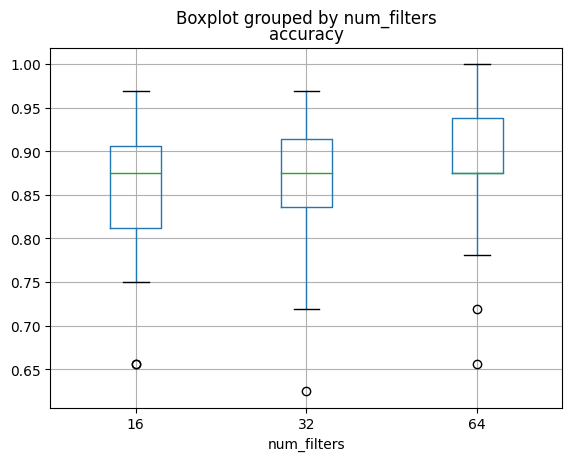

In [4]:
ax = df.boxplot('accuracy', 'num_filters')

<AxesSubplot: title={'center': 'accuracy'}, xlabel='c1_ksize'>

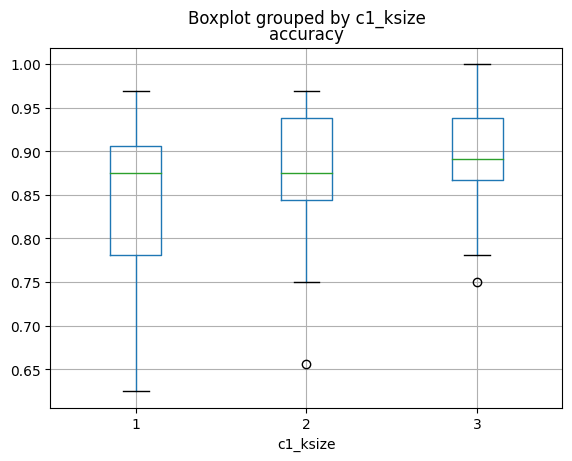

In [5]:
df.boxplot('accuracy', 'c1_ksize')
# df['']

<AxesSubplot: title={'center': 'accuracy'}, xlabel='c2_ksize'>

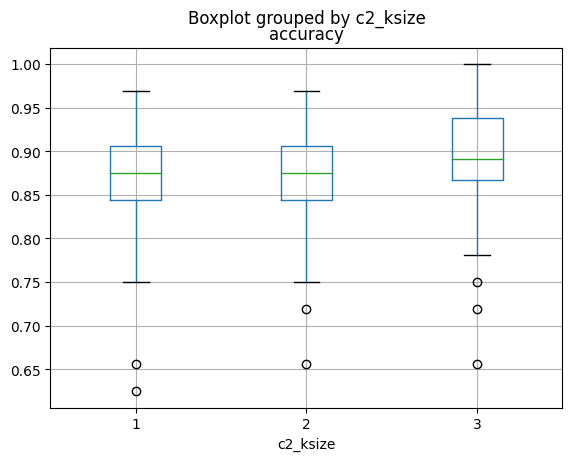

In [6]:
df.boxplot('accuracy', 'c2_ksize')

De resultaten suggereren: grotere kernels zijn beter, meer filters ook, maar er is wel veel overlap.

Wellicht speelt stride een rol?

<AxesSubplot: title={'center': 'accuracy'}, xlabel='c1_stride'>

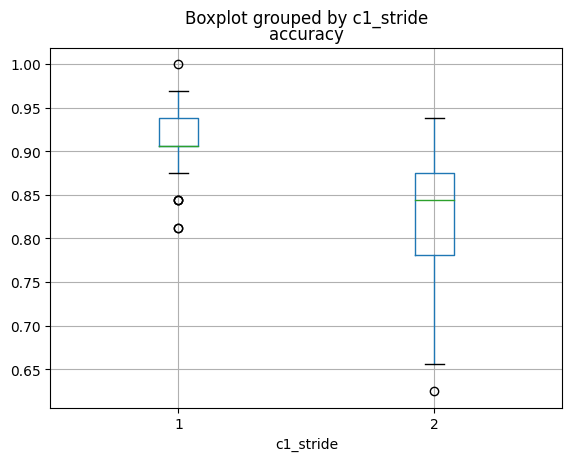

In [7]:
df.boxplot('accuracy', 'c1_stride')

<AxesSubplot: title={'center': 'accuracy'}, xlabel='c2_stride'>

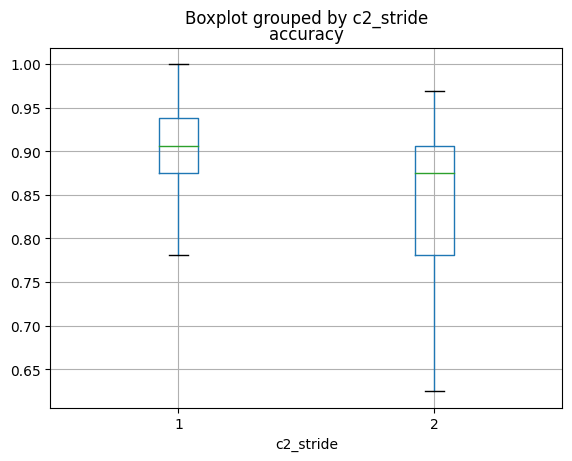

In [8]:
df.boxplot('accuracy', 'c2_stride')

Nou en of. Vooral c1 stride zorgt voor duidelijke verschillen.

Eens kijken wat de combinatie van c1 stride en c1 kernel size oplevert

<AxesSubplot: title={'center': 'accuracy'}, xlabel='c1_ksize_stride'>

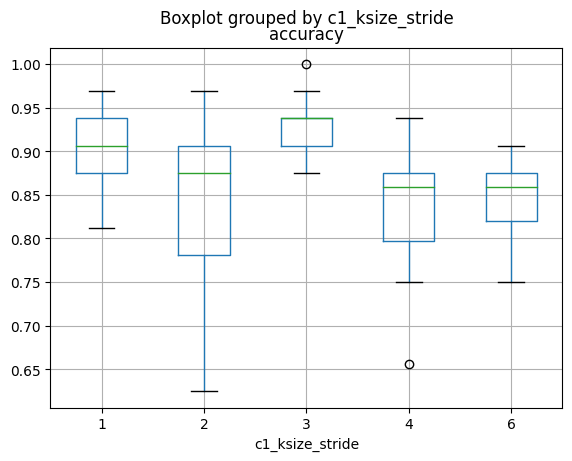

In [9]:
df['c1_ksize_stride'] = df['c1_ksize'] * df['c1_stride']
df.boxplot('accuracy', 'c1_ksize_stride')

Dat gaat alle kanten op. Misschien eens filteren per stride?

In [16]:
df_c1_stride1 = df[df['c1_stride'] == 1]
df_c1_stride2 = df[df['c1_stride'] == 2]

<AxesSubplot: title={'center': 'accuracy'}, xlabel='c1_ksize'>

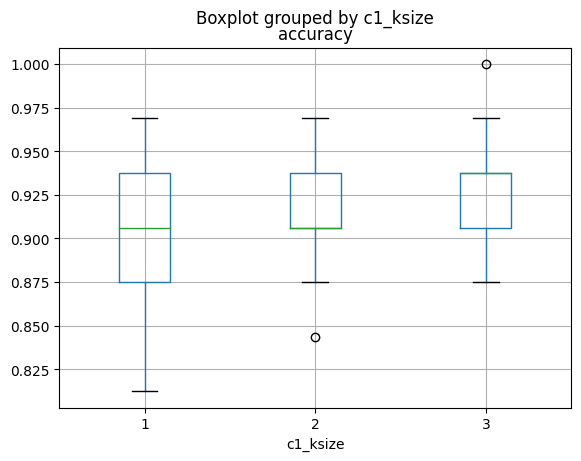

In [17]:
ax = df_c1_stride1.boxplot('accuracy', 'c1_ksize')
ax.get_figure().suptitle('Accuracy vs c1_ksize (stride = 1)')


Text(0.5, 0.98, 'Accuracy vs c1_ksize (stride = 2)')

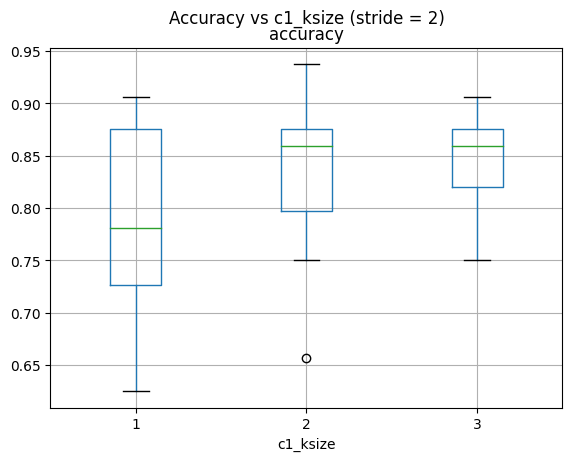

In [33]:
ax = df_c1_stride2.boxplot('accuracy', 'c1_ksize')
ax.get_figure().suptitle('Accuracy vs c1_ksize (stride = 2)')
